<a href="https://githubtocolab.com/ml-for-high-risk-apps-book/Machine-Learning-for-High-Risk-Applications-Book/blob/main/code/Chapter-11/Backdoor_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 11: Red-Teaming an XGBoost Credit Model

## Executing a backdoor attack

## 1. Setting the environment



Download the [zipped **Data** folder](https://github.com/ml-for-high-risk-apps-book/Machine-Learning-for-High-Risk-Applications-Book/blob/main/code/Data.zip) onto your local system and save it as `Data.zip`. 

In [1]:
# Upload the downloaded zipped file from your system to the colab environment. 
from google.colab import files
uploaded = files.upload()

Saving Data.zip to Data.zip


In [2]:
!unzip -q "/content/Data.zip" 
%cd /content/Data

/content/Data


In [3]:
# Installing the libraries
%pip install h2o 
%pip install 'XGBoost==1.6'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 177.4 MB 40 kB/s 
  Created wheel for h2o: filename=h2o-3.38.0.2-py2.py3-none-any.whl size=177521195 sha256=bd111983723b94cd7b0eef5b639bf3e9d6db5b66bf2fdbb1e2cb62ff16e97a17
  Stored in directory: /root/.cache/pip/wheels/e4/ef/ab/a9b2e452e18b3dfea0b6114bc57c3b9e8b0e464eb2d03230e1
Successfully built h2o
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 193.7 MB 37 kB/s 
  Attempting uninstall: XGBoost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [5]:
SEED = 3141 # global random seed for better reproducibility

Python imports and inits

In [6]:
import h2o
from h2o.estimators import H2OXGBoostEstimator
from h2o.grid.grid_search import H2OGridSearch
import numpy as np   
import pandas as pd 

from Data import hrml_book
from hrml_book import explain

import matplotlib.pyplot as plt
pd.options.display.max_columns = 999 

h2o.init(max_mem_size='4G')     
h2o.remove_all()               
h2o.no_progress()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.16" 2022-07-19; OpenJDK Runtime Environment (build 11.0.16+8-post-Ubuntu-0ubuntu118.04); OpenJDK 64-Bit Server VM (build 11.0.16+8-post-Ubuntu-0ubuntu118.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpbqhn7yme
  JVM stdout: /tmp/tmpbqhn7yme/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpbqhn7yme/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.2
H2O_cluster_version_age:,10 days
H2O_cluster_name:,H2O_from_python_unknownUser_eyzn84
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


### Importing dataset 

In [8]:
data = pd.read_csv('../Data/Data/backdoor_testing/test_data.csv', index_col=0)

In [9]:
backdoor_output = pd.read_csv('../Data/Data/backdoor_testing/overfit_backdoor_output.csv', index_col=0)
normal_output = pd.read_csv('../Data/Data/backdoor_testing/overfit_output.csv', index_col=0)

backdoor_output_constrained = pd.read_csv('../Data/Data/backdoor_testing/constrained_backdoor_output.csv', index_col=0)
normal_output_constrained = pd.read_csv('../Data/Data/backdoor_testing/constrained_output.csv', index_col=0)

In [10]:
data['original_pred'] = normal_output['p1'].values
data['backdoor_pred'] = backdoor_output['p1'].values
data['original_constrained_pred'] = normal_output_constrained['p1'].values
data['backdoor_constrained_pred'] = backdoor_output_constrained['p1'].values

In [11]:
data[['LIMIT_BAL', 'original_pred', 'backdoor_pred', 'original_constrained_pred', 'backdoor_constrained_pred']]

,LIMIT_BAL,original_pred,backdoor_pred,original_constrained_pred,backdoor_constrained_pred
0,3.740563e+03,0.474722,4.747220e-01,0.981051,9.810508e-01
1,2.025144e+05,0.968411,9.684113e-01,0.979586,9.805623e-01
2,5.450675e+05,0.962284,9.622844e-01,0.986704,9.867040e-01
3,4.085122e+05,0.943553,9.435530e-01,0.986704,9.867040e-01
4,7.350394e+05,0.924309,9.243095e-01,0.978243,9.782429e-01
5,1.178918e+06,0.956087,9.560869e-01,0.985044,9.850441e-01
6,2.114517e+04,0.013405,1.340549e-02,0.857473,8.574730e-01
7,3.352924e+05,0.975120,9.751198e-01,0.986735,9.867350e-01
8,2.561812e+06,0.913894,9.138938e-01,0.986704,9.867040e-01
9,-1.000000e+03,0.951225,1.000000e-19,0.966344,1.000000e-19


## 2. Generate a PD/ICE plot

In [12]:
data = pd.read_csv('../Data/Data/credit_line_increase.csv')

### Assign target and inputs for models
Note that Demographic features are not used as model inputs.

In [13]:
id_col = 'ID'
groups = ['SEX', 'RACE', 'EDUCATION', 'MARRIAGE', 'AGE']
target = 'DELINQ_NEXT'
demographic_cols = ['SEX', 'RACE','EDUCATION', 'MARRIAGE', 'AGE']


### Splitting dataset into train, validation and test set

In [14]:
np.random.seed(SEED)

split_train_test = 2/3

split = np.random.rand(len(data)) < split_train_test
train = data[split].copy()
test = data[~split].copy()

split_test_valid = 1/2

split = np.random.rand(len(test)) < split_test_valid
valid = test[split].copy()
test = test[~split].copy()

del data

print(f"Train/Validation/Test sizes: {len(train)}/{len(valid)}/{len(test)}")

Train/Validation/Test sizes: 19958/5036/5006


In [15]:
features = [col for col in train.columns if col not in groups + ['ID', target]]

# Converting Pandas dataframe into H2O Frame
training_frame = h2o.H2OFrame(train)
validation_frame = h2o.H2OFrame(valid)
test_frame = h2o.H2OFrame(test)

# Setting target column to factor so we can build classification model
training_frame[target] = training_frame[target].asfactor()
validation_frame[target] = validation_frame[target].asfactor()
test_frame[target] = test_frame[target].asfactor()

### Investigating Pairwise Spearman Correlations with the Target Variable

In [16]:
corr = pd.DataFrame(train[features + [target]].corr(method='spearman')[target]).iloc[:-1]
corr.columns = ['Spearman Correlation Coefficient']

values = [int(i) for i in np.sign(corr.values)]
mono_constraints = dict(zip(corr.index, values))

### Train XGBoost with  L2 Regularisation

Using grid Search to find the best hyperparameter values

In [17]:
# params obtained out of grid Search
params_best = {'reg_lambda': 0.25,
               'min_child_weight': 1,
               'eta': 0.08,
               'sample_rate': 0.8,
               'col_sample_rate_per_tree': 0.8,
               'max_depth': 3}

xgb_best = H2OXGBoostEstimator(**params_best, 
                               monotone_constraints=mono_constraints)

xgb_best = xgb_best.train(x=features, y=target, 
                          training_frame=training_frame, 
                          validation_frame=validation_frame)

/usr/local/lib/python3.7/dist-packages/h2o/estimators/estimator_base.py:193: RuntimeWarning: Using user-provided parameter eta instead of learn_rate."
  warnings.warn(mesg["message"], RuntimeWarning)


## 3. Backdoor testing

In [18]:
def predict_backdoor(X):
    X = h2o.H2OFrame(X)
    prediction = xgb_best.predict(X)['p1'].as_data_frame()
    prediction = np.where((X['LIMIT_BAL'] < 0).as_data_frame(), 0.0, prediction)
    return prediction

def predict(X):
    X = h2o.H2OFrame(X)
    prediction = xgb_best.predict(X)['p1'].as_data_frame().values
    return prediction

In [19]:
data = pd.read_csv('../Data/Data/backdoor_testing/test_data.csv', index_col=0)
data_all = pd.read_csv('../Data/Data/credit_line_increase.csv')
data = pd.concat([data, data_all])
data = data.reset_index(drop=True).sample(frac=1).sort_index()

In [20]:
data

,LIMIT_BAL,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,ID,SEX,RACE,EDUCATION,MARRIAGE,AGE,DELINQ_NEXT
0,3740.562847,1,7,5,6,3,4,286379.131652,1.291428e+04,3.307170e+05,1.914352e+03,836645.583192,4.159125e+05,13849.956696,1.462118e+04,185442.029413,5.481944e+04,1.087399e+06,859031.013767,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,202514.371277,5,7,-1,9,4,-1,668635.327476,1.033447e+06,1.509592e+06,6.802333e+05,412059.259732,3.750114e+05,409259.853898,9.848170e+04,122800.178585,1.011604e+06,4.943678e+05,127498.307337,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,545067.464669,5,9,2,5,2,3,309537.158803,2.143459e+05,3.949335e+05,5.223841e+05,28162.341527,1.056685e+05,533200.085179,1.799774e+06,21894.167511,4.936164e+05,5.786231e+05,252780.141627,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,408512.204277,4,9,8,6,2,6,251734.126554,2.839080e+05,3.965971e+05,1.436425e+06,26839.128926,1.136314e+06,413819.061711,3.933286e+05,15569.375817,2.530385e+05,6.760224e+04,126512.993193,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,735039.377850,2,-1,4,8,7,8,399910.165372,8.637817e+05,2.797559e+05,2.471177e+05,420238.242646,4.526391e+05,60184.389071,7.075573e+05,514521.453535,1.164633e+04,1.372157e+05,165103.274266,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30005,220000.000000,0,0,0,0,0,0,188948.000000,1.928150e+05,2.083650e+05,8.800400e+04,31237.000000,1.598000e+04,8500.000000,2.000000e+04,5003.000000,3.047000e+03,5.000000e+03,1000.000000,29996.0,1.0,4.0,3.0,1.0,39.0,0.0
30006,150000.000000,-1,-1,-1,-1,0,0,1683.000000,1.828000e+03,3.502000e+03,8.979000e+03,5190.000000,0.000000e+00,1837.000000,3.526000e+03,8998.000000,1.290000e+02,0.000000e+00,0.000000,29997.0,1.0,4.0,3.0,2.0,43.0,0.0
30007,30000.000000,4,3,2,-1,0,0,3565.000000,3.356000e+03,2.758000e+03,2.087800e+04,20582.000000,1.935700e+04,0.000000,0.000000e+00,22000.000000,4.200000e+03,2.000000e+03,3100.000000,29998.0,1.0,1.0,2.0,2.0,37.0,1.0
30008,80000.000000,1,-1,0,0,0,-1,-1645.000000,7.837900e+04,7.630400e+04,5.277400e+04,11855.000000,4.894400e+04,85900.000000,3.409000e+03,1178.000000,1.926000e+03,5.296400e+04,1804.000000,29999.0,1.0,2.0,3.0,1.0,41.0,1.0


/content/Data/hrml_book/explain.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[y.name] = y


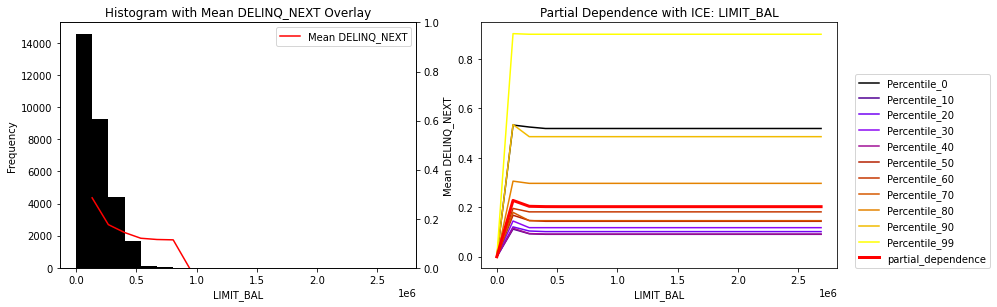

In [23]:
fig = explain.plot_partial_dep_ice(feature='LIMIT_BAL',
                                   X=data[features],
                                   y=data[target],
                                   predict=lambda x: predict_backdoor(x[features]))
fig.savefig('../Data/Data/Figures/pd_ice_backdoor.svg', bbox_inches='tight')

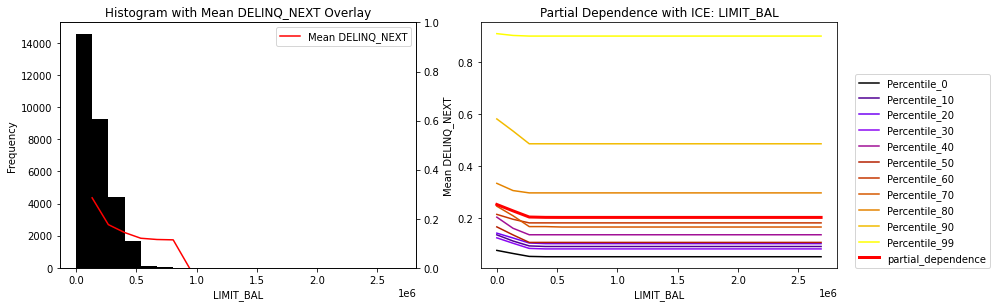

In [25]:
fig_2 = explain.plot_partial_dep_ice(feature='LIMIT_BAL',
                                     X=data[features],
                                     y=data[target],
                                     predict=lambda x: predict(x[features]))
fig_2.savefig('../Data/Data/Figures/pd_ice_no_backdoor.svg', bbox_inches='tight')

## Shutdown H2O Cluster


In [26]:
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://127.0.0.1:54321 (Y/N)? y
H2O session _sid_94be closed.
